# Tutorial: Model Calibration with Markov chain Monte Carlo

The purpose of this tutorial is to demonstrate how to use Markov chain Monte Carlo (MCMC) to calibrate a model. By calibration, we mean the selection of model parameters (and, when relevant, structures). This tutorial notebook will build on the HYMOD sensitivity analysis notebook.

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import random
from scipy import stats

import msdbook
import msdbook.hymod
from msdbook.package_data import load_hymod_input_file

##### **NOTE:**  If you are running this notebook locally, uncomment the following code to install the required package data:

In [2]:
# from msdbook.install_supplement import install_package_data
# install_package_data()

## 1. MCMC for Model Calibration and Uncertainty Quantification

### 1.1 Bayesian Uncertainty Quantification

A common goal in model development and diagnostics is *calibration*, or the identification of model structures and parameters which are consistent with data. While models can be calibrated through hand-tuning parameters or minimizing simple error metrics such as root-mean-square-error (RMSE), these approaches can underrepresent the probabilistic nature of the data-generating process, as well as the potential for multiple model configurations to be consistent with the data. Probabilistic uncertainty quantification, which is the topic of this notebook, can address these concerns.

The notion that different model configurations can be consistent with data to different degrees is related to the Bayesian interpretation of probability as representing the degree of belief in an outcome. Bayesian uncertainty quantification has two characteristics:

1. Obtaining probability distributions over model structures and/or parameter values $\theta$ reflecting consistency with prior beliefs $p(\theta)$ and data $y$. These probabilities represent the *posterior* probability emerging from Bayes' Rule, $$p(\theta | y) \propto p(y |\theta) p(\theta),$$ where $p(y | \theta)$ is the *likelihood* of seeing the data given the parameterization $\theta$. The likelihood captures the probability model by which the data is observed and can include bias terms, observation errors, or other influences.
2. The use of prior distributions. Priors are classically thought of as means to express beliefs about admissible or plausible values, but they can also be used to limit the degree of overfitting by requiring more data to force more extreme parameter estimates.

The fundamental challenge is that of sampling from the posterior probability distribution, which may not have a nice representation.
MCMC is one family of approaches to solving that challenge.

### 1.2 Markov chain Monte Carlo

Markov chain Monte Carlo (MCMC) is a family of algorithms to sample from (almost) arbitrary probability distributions. The underlying idea is to construct a Markov chain of samples whose stationary distribution is the same as the target distribution $\pi$. That the target distribution is the *stationary* distribution of the constructed chain is important for [diagnostics](#4-tips-for-using-mcmc).

While there are many MCMC algorithms, the most fundamental is the **Metropolis-Hastings algorithm**. We will focus on the Metropolis-Hastings algorithm in this tutorial, as it makes the MCMC procedure and the impacts of choices transparent, though [other approaches](#3-challenges-and-next-steps) can scale better.

The Metropolis-Hastings algorithm relies on an accept-reject step to ensure that the resulting Markov transition probabilities have the right properties to ensure convergence to the target distribution $\pi$. This requires the specification of a *proposal distribution* $q$.

0. Start from an initial parameter value $x_0$.

Given $X_t = x_t$:
1. Generate $Y_t \sim q(y | x_t)$;
2. Set $X_{t+1} = Y_t$ with probability $\rho(x_t, Y_t)$,
where
$$
\rho(x, y) = \min \left\{\frac{\pi(y)}{\pi(x)}\frac{q(x | y)}{q(y | x)}, 1\right\},
$$
else set $X_{t+1} = x_t$.

Often the proposal distribution is chosen to be symmetric, $q(y | x) = q(x | y)$, so the accept-reject probability $\rho(x, y) = \min\{\pi(y)/\pi(x), 1\}$. We will look later at the impact of choices of $q$ and some adaptive approaches.

In code form, the Metropolis-Hastings algorithm looks like this.

In [3]:
# Inputs:
#   - num_iter: Int, number of iterations to run Metropolis_Hastings algorithm
#   - proposal_sd: List or vector of proposal standard deviations, corresponding to each parameter
#   - p0: initial parameter vector
#   - logposterior: function to calculate the log-posterior for a given parameter vector
# Outputs:
#   - parameters: matrix of sampled parameters, num_iter x num_parameters
#   - lp: vector of log-posterior values for the sampled parameters
#   - accept_rate: Float of the percentage of proposals which were accepted.

def metropolis(num_iter, proposal_sd, p0, logposterior):
    # Initialize our lists for sampled parameters and log-posterior values
    # Create empty array
    parameters = np.zeros((num_iter+1, np.size(p0)))
    lp = np.zeros(num_iter+1)
    # Set initial values
    parameters[0, :] = p0
    lp[0] = logposterior(p0)
    # Set up proposal covariance matrix 
    cov = stats.Covariance.from_diagonal(np.square(proposal_sd))
    acceptances = 0
    for i in range(1, num_iter + 1):
        # Propose a new state
        proposal = stats.multivariate_normal.rvs(mean=parameters[i-1, :], cov=cov)
        # Calculate the acceptance probability
        lp_proposal = logposterior(proposal)
        p_accept = lp_proposal - lp[i-1]
        p_accept = np.min([p_accept, 0])
        u = stats.uniform.rvs()
        # Accept with probability p_accept
        if u < np.exp(p_accept):
            # Add the proposed parameter to the end of the list `parameters`
            parameters[i, :] = proposal
            # Add the corresponding posterior score to the end of that list too
            acceptances += 1
            lp[i] = lp_proposal
        # Reject with probability 1-p_accept
        else:
            # Add another copy of the current parameter value to the end of the list `parameters`
            parameters[i, :] = parameters[i-1, :]
            # Add the corresponding posterior score to the end of that list too
            lp[i] = lp[i-1]
    # Calculate the acceptance rate; this is a useful diagnostic
    accept_rate = acceptances / num_iter
    # Leave off the initial value but return the rest
    return parameters[1:], lp[1:], accept_rate

## 2. HYMOD Calibration

Let's look at how well HYMOD with some default parameters explain the streamflow data. This example may take a while to converge; HYMOD is sufficiently complex (both computationally and in terms of dynamics) that this "naive" approach to MCMC is relatively slow on a local machine. We will discuss some alternative approaches for this category of models in Section 3.

In [5]:
# load the Leaf River HYMOD input file
leaf_data = load_hymod_input_file()

# extract the first eleven years of data
leaf_data = leaf_data.iloc[0:4015].copy()

print('Leaf River Data structure:')

# There are only three columns in the file including precipitation, potential evapotranspiration, and streamflow
leaf_data.head()

Leaf River Data structure:


,Precip,Pot_ET,Strmflw
0,0.0,4.60,0.29
1,0.0,4.31,0.24
2,0.0,4.33,0.21
3,0.0,4.78,0.19
4,0.0,2.91,0.18


Let's look at how well the model performs with some default parameter values.

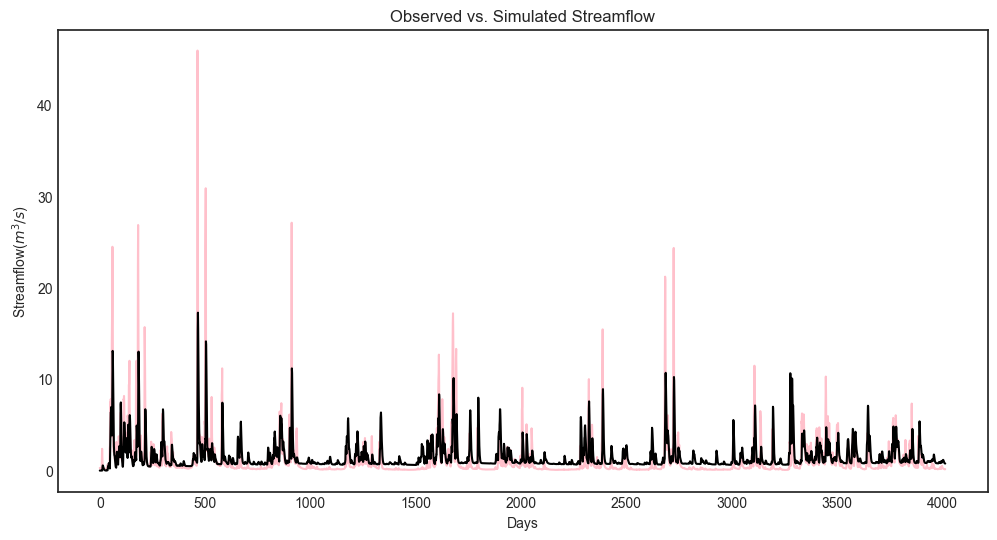

In [6]:
# assign input parameters to generate a baseline simulated streamflow
Nq = 3  # Number of quickflow routing tanks 
Kq = 0.5 # Quickflow routing tanks' rate parameter    
Ks =  0.001 # Slowflow routing tank's rate parameter           
Alp = 0.5 # Quick/slow split parameter   
Huz = 100 # Maximum height of soil moisture accounting tank  
B = 1.0 # Scaled distribution function shape parameter    

# Note that the number of years is 11. One year of model warm-up and ten years are used for actual simulation
model = msdbook.hymod.hymod(Nq, Kq, Ks, Alp, Huz, B, leaf_data, ndays=4015)
ax = msdbook.hymod.plot_observed_vs_simulated_streamflow(df=leaf_data, hymod_dict=model)

We can see that this HYMOD parameterization generally does well, but tends to underestimate the peak streamflows. Can we do better?

First, we need to specify a probability model for the data. To do this, we can write the data $y_t$ as the sum of the model output $F(\theta_F; \mathbf{x}_t)$ (where $\theta_F$ is the parameter vector and $\mathbf{x}_t$ are the exogenous model forcings) and the residuals $\mathbf{z}_t(\theta_z)$, where $\theta_z$ are the statistical parameters used to describe the residual distribution. The residual probability model can be relatively simple, such as the common assumption that $\mathbf{z}_t$ are independently distributed according to a Gaussian distribution, or can be more complex, including auto-correlations, cross-correlations, and/or combinations of systematic *model data-discrepancy* and independent observation errors.

In this example, we will assume that the residuals are normally distributed (on the log scale, since HYMOD predictions and streamflow are non-negative), though in practice we would check this assumption by fitting the model and looking at residual diagnostics, such as partial autocorrelation and Q-Q plots. Since HYMOD can simulate zero streamflow, which is not in the data, we will also include a strictly positive bias term $\beta$. As a result, our probability model is

$$\begin{gather*}
\log(y_t) = \log(F(\theta_F; \mathbf{x}_t) + \beta) + z_t \\
z_t \sim \mathcal{N}(0, \sigma)
\end{gather*}$$

This means that we need the following model and statistical parameters:

1. `Nq`: the number of quickflow routing tanks;
2. `Kq`: the quickflow routing tanks' rate parameter;
3. `Ks`: The slowflow routing tanks' rate parameter;
4. `Alp`: The quick/slow split parameter;
5. `Huz`: The maximum height of soil moisture accounting tank;
6. `B`: The scaled distribution function scale parameter;
7. `beta`: Positive bias term, since HYMOD can produce zero simulated streamflow;
7. `sigma`: Standard deviation of the log-residual normal distribution.

### 2.1: Prior Distributions

MCMC lets us sample from arbitrary probability distributions, including Bayesian posterior distributions. One advantage of a Bayesian approach to model calibration is that it lets us include prior information for parameter values, which can help guide inferences towards mechanistically reasonable values. In the absence of firm prior information about parameter values, we can check that prior distributions result in reasonable simulations with a *prior predictive check*. Let's start with the following priors, which we assume are independent across parameter.

1. `Kq`: $\text{LogNormal}(0.25, 0.5)$;
2. `Ks`: $\text{LogNormal}(0.95, 0.003)$;
3. `Alp`: $\text{Beta}(2, 2)$;
4. `Huz`: $\mathcal{N}(100, 20)$;
5. `B`: $\text{LogNormal}(0.1, 1)$;
6. `beta`: $\text{LogNormal}(0.05, 0.5)$;
6. `sigma`: $\text{LogNormal}(0.5, 0.5)$.

To conduct a prior predictive check, we will generate samples from these distributions, evaluate the model (and add residuals), and then look at the distribution of output (or output summary statistics) about which we have some intuition about what are reasonable values. Note that we will not explicitly compare these results to the data, we do not want to overfit.

(array([ 11.,  57., 149., 253., 274., 164.,  72.,  14.,   5.,   1.]),
 array([0.42775933, 0.44519798, 0.46263663, 0.48007528, 0.49751394,
        0.51495259, 0.53239124, 0.54982989, 0.56726855, 0.5847072 ,
        0.60214585]),
 <BarContainer object of 10 artists>)

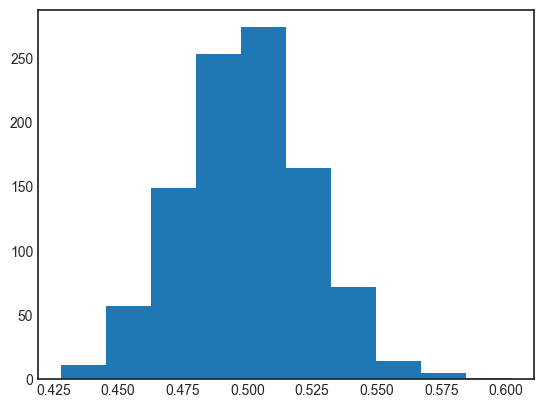

In [7]:
plt.hist(stats.lognorm(s=0.05, scale=0.5).rvs(1000))

In [8]:
ndays = 4015
nsamples = 1000

# generate prior samples
Kq_prior = stats.lognorm(s=0.25, scale=0.5)
Ks_prior = stats.lognorm(s=0.95, scale=0.003)
Alp_prior = stats.beta(2, 2)
Huz_prior = stats.norm(100, 20)
B_prior = stats.lognorm(s=0.1, scale=1)
beta_prior = stats.lognorm(s=0.05, scale=0.25)
sigma_prior = stats.lognorm(s=0.25, scale=0.25)

Kq = Kq_prior.rvs(nsamples)
Ks = Ks_prior.rvs(nsamples)
Alp = Alp_prior.rvs(nsamples)
Huz = Huz_prior.rvs(nsamples)
B = B_prior.rvs(nsamples)
beta = beta_prior.rvs(nsamples)
sigma = sigma_prior.rvs(nsamples)

# preallocate output storage
prior_out = np.zeros((ndays, nsamples))

# note that we include the error/noise in these simulations
for i in range(nsamples):
    prior_out[:, i] = np.exp(np.log(msdbook.hymod.hymod(3, Kq[i], Ks[i], Alp[i], Huz[i], B[i], leaf_data, ndays=ndays)['Q'] + beta[i]) + stats.norm(0, sigma[i]).rvs(ndays))

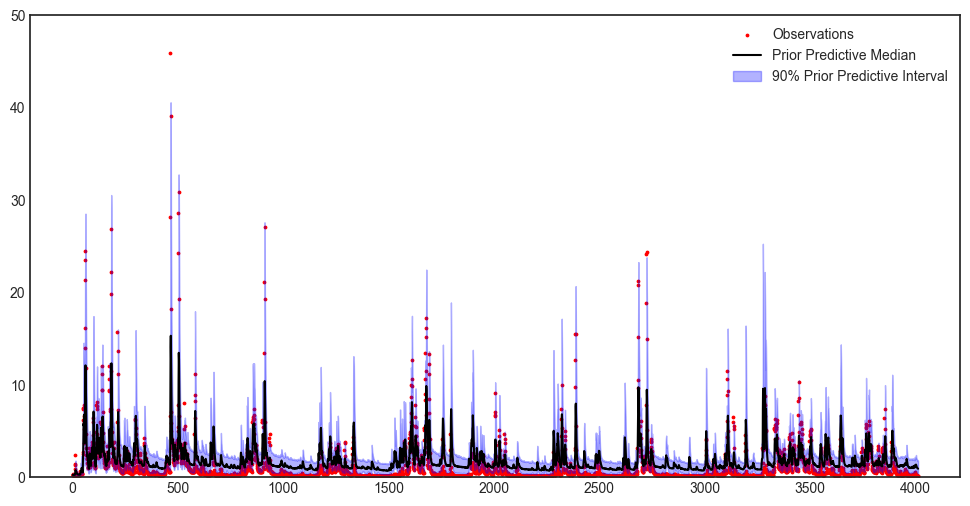

In [9]:
# compute 90% prediction interval for each time step
prior_q90 = np.quantile(prior_out, [0.05, 0.5, 0.95], axis=1)
fig, strmflw_ax = plt.subplots(figsize=[12,6])
strmflw_ax.set_ylim([0, 50])
strmflw_ax.scatter(range(0, ndays), leaf_data.Strmflw, color="red", s=3)
strmflw_ax.plot(range(0, ndays), prior_q90[1, :], color="black")
strmflw_ax.fill_between(range(0, ndays), prior_q90[0, :], prior_q90[2, :], color="blue", alpha=0.3)
strmflw_ax.legend(['Observations', 'Prior Predictive Median', '90% Prior Predictive Interval'], loc='upper right')

This looks reasonable as a starting point; we may not be capturing the most extreme data in our 90% interval, but we also wouldn't expect to, and as none of our priors are uniform, we are not closing off the possibility that the posteriors could be wider.

### 2.2 Metropolis-Hastings

To implement the Metropolis-Hastings algorithm, we'll start by writing functions to compute the log-posterior of the probability model.

In [10]:
def log_prior(Kq, Ks, Alp, Huz, B, beta, sigma):
    lp = 0
    lp += stats.lognorm.logpdf(Kq, s=0.25, scale=0.5)
    lp += stats.lognorm.logpdf(Ks, s=0.95, scale=0.003)
    lp += stats.beta.logpdf(Alp, 2, 2)
    lp += stats.norm.logpdf(Huz, 100, 20)
    lp += stats.lognorm.logpdf(B, s=0.1, scale=1)
    lp += stats.lognorm.logpdf(beta, s=0.05, scale=0.25)
    lp += stats.lognorm.logpdf(sigma, s=0.5, scale=0.25)
    return lp


def log_likelihood(Kq, Ks, Alp, Huz, B, beta, sigma, leaf_data, ndays):
    hymod_out = msdbook.hymod.hymod(3, Kq, Ks, Alp, Huz, B, leaf_data, ndays=ndays)['Q']
    residuals = np.log(leaf_data['Strmflw']) - np.log(hymod_out + beta) # compute residuals
    ll = np.sum(stats.norm.logpdf(residuals, scale=sigma))
    return ll


def log_posterior(params, leaf_data=leaf_data, ndays=4015):
    Kq, Ks, Alp, Huz, B, beta, sigma = tuple(params[0])
    lp = log_prior(Kq, Ks, Alp, Huz, B, beta, sigma)
    # only evaluate the model if the log-prior > -Inf
    if not (math.isinf(lp) and lp < 0):
        ll = log_likelihood(Kq, Ks, Alp, Huz, B, beta, sigma, leaf_data, ndays)
        lp += ll
    return lp

Next, we'll implement the Metropolis-Hastings algorithm. The number of iterations is set to 100,000, which is needed for convergence. The `metropolis()` function may take a long time to run (75-290 min), to speed this up, reduce the `niter` parameter (ex. `niter = 1000`). 

In [11]:
niter = 100000

init_params = np.array([[1.0, 0.5, 0.5, 100, 1.0, 0.1, 0.5]])
proposal_sd = [0.005, 0.001, 0.005, 1.0, 0.005, 0.001, 0.005]

In [12]:
out = metropolis(niter, proposal_sd, init_params, log_posterior)

What is the acceptance rate? Both too high and too low of an acceptance rate suggest something is off with how our sampler is balancing exploration and exploitation. The theoretical "ideal" is between 24-45%.

In [13]:
out[2]

0.27565

To provide some evidence for convergence, let's look at the traceplots. We'll look at a burn-in of 1/10 the number of iterations; this may need to change depending on the number of iterations you run (e.g. if the traceplot after the red vertical line appears to shift versus appearing roughly stationary for the rest of the chain).

Text(0.5, 0, 'Iteration')

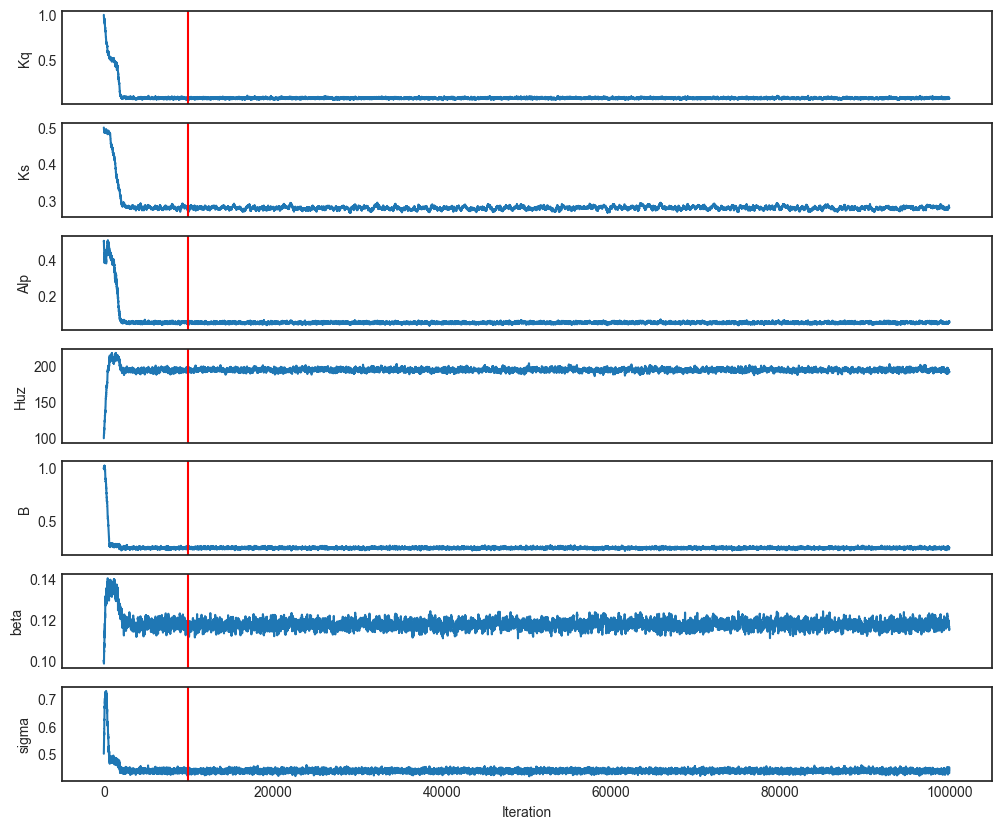

In [14]:
parnames = ["Kq", "Ks", "Alp", "Huz", "B", "beta", "sigma"]
nburn = int(niter / 10)
fig, axs = plt.subplots(7, 1, sharex=True, figsize=[12, 10])
for i in range(0, 7):
    axs[i].plot(out[0][:, i])
    axs[i].axvline(x=nburn, color="red") # modify x to look at other burnin lengths
    axs[i].set_ylabel(parnames[i])
axs[6].set_xlabel("Iteration")

We can see that we might have converged by 10,000 iterations (or possibly earlier). We will discard the samples from before this point as burn-in since they have an unrepresentative probability in the sampled chain.

Let's zoom in on the samples from after this point.

Text(0.5, 0, 'Iteration')

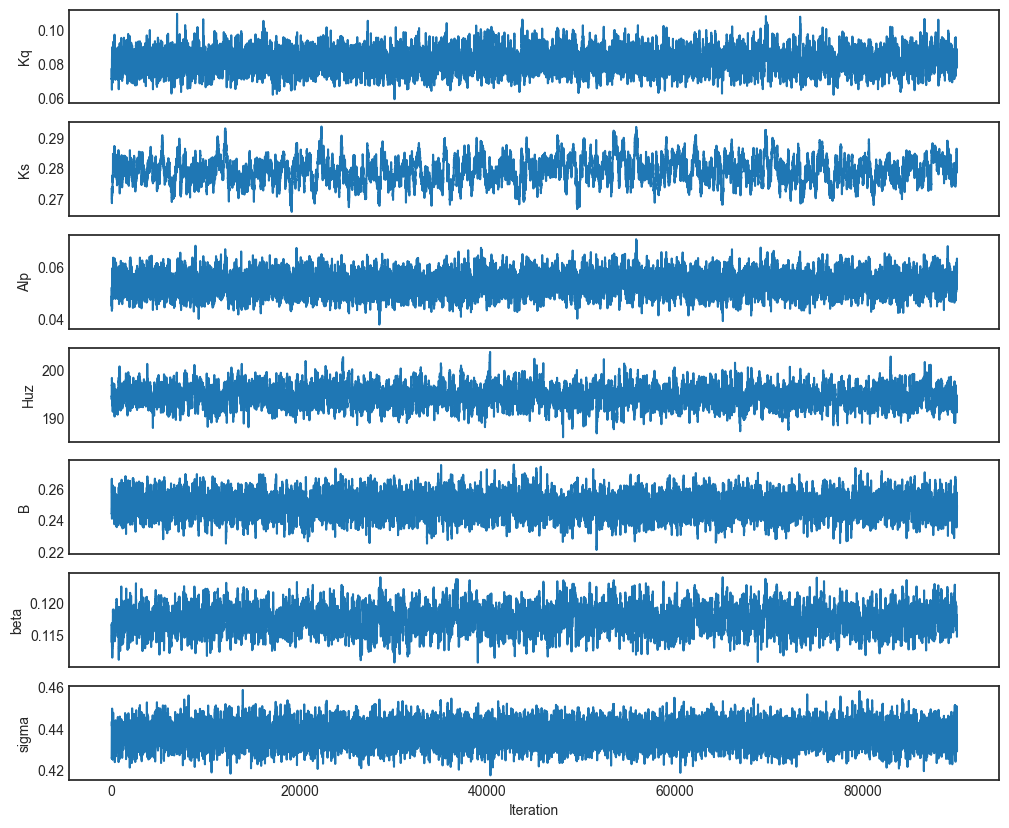

In [15]:
fig, axs = plt.subplots(7, 1, sharex=True, figsize=[12, 10])
for i in range(0, 7):   
    axs[i].plot(out[0][(nburn+1):niter, i])
    axs[i].set_ylabel(parnames[i])
axs[6].set_xlabel("Iteration")

These chains look like a "hairy caterpillar", which is the ideal pattern for the chain to mix well and sample systematically throughout the posterior distribution. If our proposal distribution had been too narrow, we would have accepted many more samples, but the traceplot above would look like a narrow line "dragging" slowly, instead of bouncing around. If it had been too wide, we would have rejected many more samples, and the traceplot would have looked more like a city skyline, as the sampler would have gotten stuck at the same value for a long time.

A further check for convergence is to look at how the samples change between the first half of the post-burn-in chain and its entirety. If the second half of the samples do not materially change the distribution, that is evidence for convergence.
To check convergence more systematically, we could also run multiple chains starting at different initial conditions to check that the chains reach roughly the same distribution, but we will skip that for now. 

Let's look at the resulting parameter distributions.

Text(0, 0.5, 'Count')

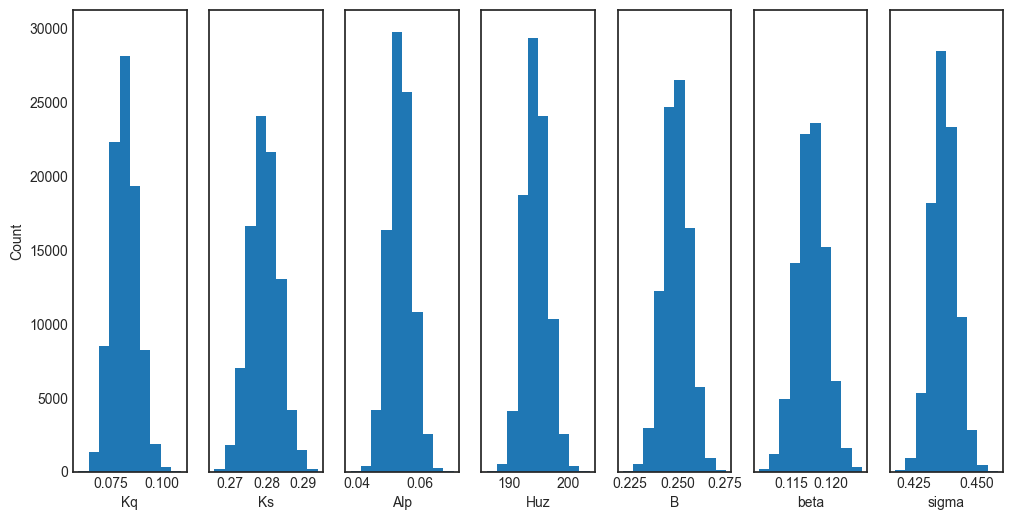

In [16]:
parbase = [0.5, 0.001, 0.5, 100, 1.0] # Scaled distribution function shape parameter    
fig, axs = plt.subplots(1, 7, figsize=[12,6], sharey=True)
for i in range(0, 7):
    axs[i].hist(out[0][(nburn+1):niter, i])
    axs[i].set_xlabel(parnames[i])
axs[0].set_ylabel("Count")

Now, let's simulate from the posterior distribution to see how well we capture the observed streamflow.

In [17]:
nsamp = 2000
idx = random.choices(range((nburn+1), niter), k=nsamp)

# simulate
hymod_sim = np.zeros((ndays, nsamp))
for index, i in enumerate(idx):
    hymod_sim[:, index] = np.exp(np.log(msdbook.hymod.hymod(3, out[0][i, 0], out[0][i, 1], out[0][i, 2], out[0][i, 3], out[0][i, 4], leaf_data, ndays=ndays)['Q'] + out[0][i, 5]) + stats.norm(0, out[0][i, 6]).rvs(ndays))

# compute quantiles
hymod_q = np.quantile(hymod_sim, [0.05, 0.5, 0.95], axis=1)

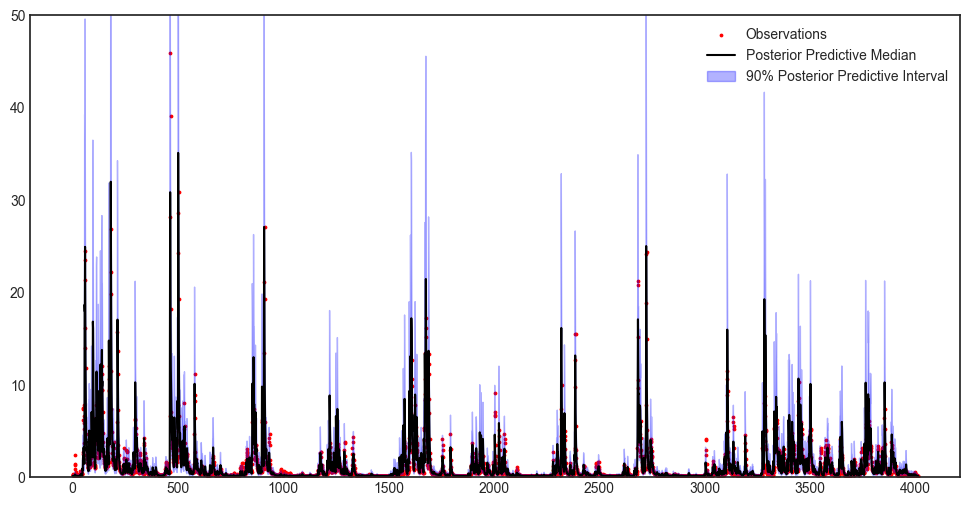

In [18]:
fig, strmflw_ax = plt.subplots(figsize=[12,6])
strmflw_ax.set_ylim([0, 50])
strmflw_ax.scatter(range(0, ndays), leaf_data.Strmflw, color="red", s=3)
strmflw_ax.plot(range(0, ndays), hymod_q[1, :], color="black")
strmflw_ax.fill_between(range(0, ndays), hymod_q[0, :], hymod_q[2, :], color="blue", alpha=0.3)
strmflw_ax.legend(['Observations', 'Posterior Predictive Median', '90% Posterior Predictive Interval'], loc='upper right')

We can visually see that we fail to capture some of the extremes in the 90% projection interval. This is ok; we would expect about 10% of the data to be outside of the interval if the model were well-calibrated. To check, we can compute the *surprise index*, which is the fraction of points outside of the projection interval.

In [19]:
si = 1 - (sum([hymod_q[0, i] <= leaf_data.Strmflw[i] <= hymod_q[2, i] for i in range(0, ndays)]) / ndays)
si

0.09464508094645085

The surprise index is 9.3%, when we would expect it to be 10%. That's not bad (actually, it's quite good), and means that the model is well calibrated. If we wanted to dial the calibration in further (or if the surprise index were far off, like 20% or 2%), we could change the priors to be more or less restrictive as appropriate.

## 3. Challenges and Next Steps

Two of the main challenges in implementing MCMC are:

1. The complexity of the model. As MCMC can take hundreds of thousands of model evaluations, small increases in computational expense can be the difference in whether MCMC is feasible or not. Increasing number of un- or weakly-correlated parameters (model or statistical) can also pose problems, as these require more samples to fully explore and capture the distribution. Since the Metropolis-Hastings algorithm in particular is fundamentally serial (the need to burn in every chain means there is only a weak benefit to parallelization), these challenges are to some degree unavoidable without the use of a more sophisticated algorithm. 
2. Selection of the proposal distribution. The efficiency of the sampler makes a big difference in the number of needed samples and the *effective sample size* of the resulting chain. This can require a lot of tuning and gets more complex as the number of parameters increases. 
3. Specification of the likelihood/probability model. We used a fairly simple model for the HYMOD residuals, but for more complex settings, the residuals may exhibit a high degree of spatial or temporal autocorrelation or may be highly nonstationary. Developing the model and writing down the likelihood function for the error process may be intractable for some classes of models.

The first two challenges can be addressed with more advanced methods than those used here. Adaptive Metropolis-Hastings algorithms (such as those included in the `adaptMCMC` R package or `AdaptiveMCMC` in Julia) automatically tune the proposal distribution based on the acceptance rate. Much more powerful algorithms such as Hamiltonian Monte Carlo (used in the Stan family of packages, `pyMC3` in Python, and `Turing` in Julia) use information about the gradient of the posterior to sample very efficiently, though this often requires the ability to automatically differentiate external simulation models, which may or may not always be possible. 

When writing down a likelihood function is intractable, Approximate Bayesian Computing (ABC) is a likelihood-free approach which is based on comparing summary statistics, rather than computing the posterior density.


## 4. Tips for Using MCMC

In this tutorial, we saw how to implement the Metropolis-Hastings algorithm for HYMOD. In order to use Metropolis-Hastings or other MCMC algorithms to your problem, you will need to answer the following questions:

1. Do you have a probability model for the data-generating process? This could be a statistical model for the data or a model for the discrepancy between a simulation model and the data. We often begin with a relatively simple model (*e.g.* normally-distributed residuals) and add complexity based on whether residual diagnostics suggest that the probability model was appropriate. If you do not or cannot write down an appropriate probability model, you could look at likelihood-free methods such as ABC.
2. How complex is your inference problem? The more computationally complex your model or the higher the dimensionality of the parameter space, the longer MCMC will need to run to fully sample from the posterior distribution. If your model is too complex, you could begin with initial uncertainty characterization or sensitivity analyses to evaluate the extent to which dimension reduction is possible, and you could look into emulation or surrogate modeling methods. Using Hamiltonian Monte Carlo methods are also an option if your model is amenable to automatic differentiation.
3. How important is parametric uncertainty for your problem? If you're only interested in a point estimate of parameters, you could more directly optimize the posterior density to find the maximum *a posteriori* estimate instead of sampling from the posterior distribution.

If your answers to these questions suggest that MCMC is tractable and useful for your problem, you should feel free to experiment with the SLR example, including the number of iterations, the probability model specification, and the proposal distribution. The HYMOD example may also be of interest, but takes longer to run.